In [98]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# sk learn import 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns

In [99]:
print("Read people.csv...")
people = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\RedHat\people.csv',
                       dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},
                       parse_dates=['date'])


Read people.csv...


In [100]:
print("Load train.csv...")
train = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\RedHat\act_train.csv',
                        dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8},
                        parse_dates=['date'])


Load train.csv...


In [101]:
print("Load test.csv...")
test = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\RedHat\act_test.csv',
                       dtype={'people_id': np.str,
                              'activity_id': np.str},
                       parse_dates=['date'])

Load test.csv...


### Review input features

In [50]:
print ("\n\n---------------------")
print ("TRAIN SET INFORMATION")
print ("---------------------")
print ("Shape of training set:", train.shape, "\n")
print ("Column Headers:", list(train.columns.values), "\n")
print (train.dtypes)




---------------------
TRAIN SET INFORMATION
---------------------
Shape of training set: (2197291, 15) 

Column Headers: ['people_id', 'activity_id', 'date', 'activity_category', 'char_1', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'outcome'] 

people_id                    object
activity_id                  object
date                 datetime64[ns]
activity_category            object
char_1                       object
char_2                       object
char_3                       object
char_4                       object
char_5                       object
char_6                       object
char_7                       object
char_8                       object
char_9                       object
char_10                      object
outcome                        int8
dtype: object


In [51]:
import re
missing_values = []
nonumeric_values = []

print ("TRAINING SET INFORMATION")
print ("========================\n")

for column in train:
    # Find all the unique feature values
    uniq = train[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("~~Listing up to 10 unique values~~")
    print (uniq[0:10])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(train[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TRAINING SET INFORMATION

'people_id' has 151295 unique values
~~Listing up to 10 unique values~~
['ppl_100' 'ppl_100002' 'ppl_100003' 'ppl_100006' 'ppl_100013' 'ppl_100019'
 'ppl_100025' 'ppl_100028' 'ppl_100029' 'ppl_100032']

-----------------------------------------------------------------------

'activity_id' has 2197291 unique values
~~Listing up to 10 unique values~~
['act2_1734928' 'act2_2434093' 'act2_3404049' 'act2_3651215' 'act2_4109017'
 'act2_898576' 'act2_1233489' 'act2_1623405' 'act2_1111598' 'act2_1177453']

-----------------------------------------------------------------------

'date' has 411 unique values
~~Listing up to 10 unique values~~
['2023-08-26T01:00:00.000000000+0100' '2022-09-27T01:00:00.000000000+0100'
 '2023-08-04T01:00:00.000000000+0100' '2022-11-23T00:00:00.000000000+0000'
 '2023-02-07T00:00:00.000000000+0000' '2023-06-28T01:00:00.000000000+0100'
 '2022-08-10T01:00:00.000000000+0100' '2023-03-02T00:00:00.000000000+0000'
 '2022-09-13T01:00:00.000000000+0

### So we have 2197291 rows and 15 columns.
All the data is categorical except the outcome which contains yes and no . 
According to submission file , we only need activity_id and outcome.
in the dataset, people_id' has 151295 unique values and no missing values, therefore approximately 14.5 activity_id is associated with each person. There are 7 different types of activities.
All corresponding activity characteristics have 2039676 missing values except char_10 .
Each row in the activity file represents a unique activity performed by a person on a certain date. 

Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic).

Also, each activity has nan and type 'int'. We will split the activities at type and use the unique integer as the numerical value.

In [102]:
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type 0', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)

people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
    people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
    people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(0.0, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(0.0, inplace=True)


Merge...


### We drop people_id as we do not need it

In [103]:
train.head(2)

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,outcome,year_x,month_x,day_x,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y
0,ppl_100,act2_1734928,4,0,0,0,0,0,0,0,0,0,76,0,2023,8,26,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,2021,6,29
0,ppl_100,act2_2434093,2,0,0,0,0,0,0,0,0,0,1,0,2022,9,27,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,2021,6,29


In [104]:
train = train.drop(['people_id'], axis=1)

In [105]:
train.head(2)

,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,outcome,year_x,month_x,day_x,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y
0,act2_1734928,4,0,0,0,0,0,0,0,0,0,76,0,2023,8,26,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,2021,6,29
0,act2_2434093,2,0,0,0,0,0,0,0,0,0,1,0,2022,9,27,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,2021,6,29


In [106]:
#Separate label and data
Y = train['outcome']
X = train.drop(['outcome'], axis=1)

In [112]:
X = X.iloc[:,1:]

In [114]:
X.head(2)

,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,year_x,month_x,day_x,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y
0,4,0,0,0,0,0,0,0,0,0,76,2023,8,26,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,2021,6,29
0,2,0,0,0,0,0,0,0,0,0,1,2022,9,27,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,2021,6,29


In [115]:
from sklearn import preprocessing
# normalize the data attributest preprocessing
df = preprocessing.normalize(X)

## Feature Selection

In [116]:
#Find all features with more than 90% variance in values.
threshold = 0.90
vt = VarianceThreshold().fit(X)

# Find feature names
feat_var_threshold = X.columns[vt.variances_ > threshold * (1-threshold)]
feat_var_threshold

Index(['activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x',
       'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x',
       'year_x', 'month_x', 'day_x', 'group_1', 'char_2_y', 'char_3_y',
       'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y',
       'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15',
       'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21',
       'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27',
       'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33',
       'char_34', 'char_35', 'char_36', 'char_37', 'char_38', 'year_y',
       'month_y', 'day_y'],
      dtype='object')

## Top 20 most important features

In [117]:
#According to RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, Y)

feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

Index(['char_38', 'group_1', 'char_2_y', 'char_7_y', 'char_8_y', 'day_y',
       'month_x', 'char_6_y', 'month_y', 'char_4_y', 'char_3_y', 'char_9_y',
       'char_5_y', 'day_x', 'char_10_x', 'char_34', 'char_36', 'year_y',
       'char_25', 'year_x'],
      dtype='object')

### Univariate Feature Selection

In [118]:
#Select top 20 features using chi2chi2 test.
X_minmax = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, Y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored_20 = feature_scoring.sort_values('score', ascending=False).head(20)['feature'].values
feat_scored_20

array(['char_38', 'char_13', 'char_36', 'char_34', 'char_37', 'char_22',
       'char_17', 'char_20', 'char_32', 'char_19', 'char_25', 'char_21',
       'char_16', 'char_28', 'char_10_y', 'char_23', 'char_15', 'char_31',
       'char_14', 'char_27'], dtype=object)

## Final feature selection

In [119]:
features = np.hstack([
        feat_var_threshold, 
        feat_imp_20,
        feat_scored_20,
        ])

features = np.unique(features)
print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-activity_category
	-char_10_x
	-char_10_y
	-char_11
	-char_12
	-char_13
	-char_14
	-char_15
	-char_16
	-char_17
	-char_18
	-char_19
	-char_1_x
	-char_20
	-char_21
	-char_22
	-char_23
	-char_24
	-char_25
	-char_26
	-char_27
	-char_28
	-char_29
	-char_2_x
	-char_2_y
	-char_30
	-char_31
	-char_32
	-char_33
	-char_34
	-char_35
	-char_36
	-char_37
	-char_38
	-char_3_x
	-char_3_y
	-char_4_x
	-char_4_y
	-char_5_x
	-char_5_y
	-char_6_x
	-char_6_y
	-char_7_x
	-char_7_y
	-char_8_x
	-char_8_y
	-char_9_x
	-char_9_y
	-day_x
	-day_y
	-group_1
	-month_x
	-month_y
	-year_x
	-year_y


### Prepare dataset for further analysis

In [137]:
clf = GradientBoostingClassifier()

In [138]:
# Fit the model to our training data
clf = clf.fit(X, Y)
score = clf.score(X, Y)
"Mean accuracy of Random Forest: {0}".format(score)

'Mean accuracy of Random Forest: 0.8654192821979428'

In [123]:
test.head(2)

,people_id,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,year_x,month_x,day_x,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y
3,ppl_100004,act1_249281,1,5,10,5,1,6,1,1,7,4,0,2022,7,20,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,2022,7,20
3,ppl_100004,act2_230855,5,0,0,0,0,0,0,0,0,0,682,2022,7,20,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,2022,7,20


In [124]:
test = test.drop(['people_id'], axis=1)

In [125]:
test.head(2)

,activity_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,year_x,month_x,day_x,char_1_y,group_1,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y
3,act1_249281,1,5,10,5,1,6,1,1,7,4,0,2022,7,20,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,2022,7,20
3,act2_230855,5,0,0,0,0,0,0,0,0,0,682,2022,7,20,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,2022,7,20


In [127]:
# Get the test data features, skipping the first column 'PassengerId'
test_x = test.iloc[:, 1:]


In [139]:
# Predict the Survival values for the test data
test_y = list(map(int, clf.predict(test_x)))

In [140]:
test['outcome'] = test_y
test[['activity_id', 'outcome']] \
    .to_csv('results-graBoost.csv', index=False)

In [130]:
train_features = train.ix[]
test = test.ix[:, features]
X = X.ix[:, features]

print('Clean dataset shape: {}'.format(train.shape))
print('Subbmitable dataset shape: {}'.format(test.shape))
print('Train features shape: {}'.format(X.shape))
print('Target label shape: {}'. format(Y.shape))

SyntaxError: invalid syntax (<ipython-input-130-061a4287f5c5>, line 1)

In [62]:
train.head(2)

,activity_category,char_10_x,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_1_x,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_2_x,char_2_y,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,char_3_x,char_3_y,char_4_x,char_4_y,char_5_x,char_5_y,char_6_x,char_6_y,char_7_x,char_7_y,char_8_x,char_8_y,char_9_x,char_9_y,day_x,day_y,group_1,month_x,month_y,year_x,year_y
0,4,76,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,2,1,1,0,0,1,1,1,0,36,0,5,0,5,0,5,0,3,0,11,0,2,0,2,26,29,17304,8,6,2023,2021
0,2,1,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,2,1,1,0,0,1,1,1,0,36,0,5,0,5,0,5,0,3,0,11,0,2,0,2,27,29,17304,9,6,2022,2021


## PCA Visualization

In [63]:
components = 8
pca = PCA(n_components=components).fit(X)

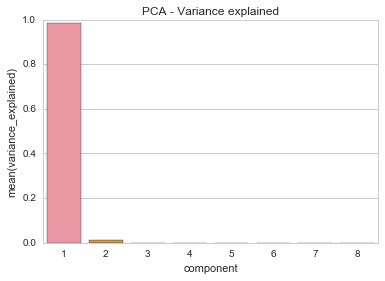

In [64]:
#Show explained variance for each component
pca_variance_explained_df = pd.DataFrame({
    "component": np.arange(1, components+1),
    "variance_explained": pca.explained_variance_ratio_            
    })

ax = sns.barplot(x='component', y='variance_explained', data=pca_variance_explained_df)
ax.set_title("PCA - Variance explained")
plt.show()

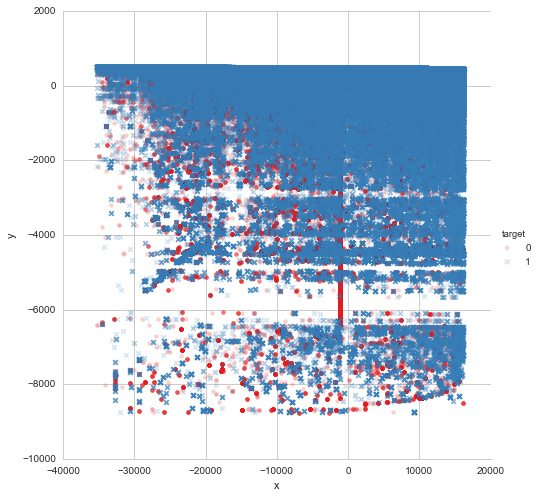

In [65]:
X_pca = pd.DataFrame(pca.transform(X)[:,:2])
X_pca['target'] = Y.values
X_pca.columns = ["x", "y", "target"]

sns.lmplot('x','y', 
           data=X_pca, 
           hue="target", 
           fit_reg=False, 
           markers=["o", "x"], 
           palette="Set1", 
           size=7,
           scatter_kws={"alpha": .2}
          )
plt.show()

### Evaluate Algorithms

In [91]:
seed = 7
processors=1
num_folds=3
num_instances=len(X)
scoring='log_loss'

kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)

In [92]:
# Prepare some basic models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
    results.append(cv_results)
    names.append(name)
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))

LR: (-0.385) +/- (0.005)
LDA: (-0.393) +/- (0.010)


In [93]:
model = AdaBoostClassifier(n_estimators=100, random_state=seed)

results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, n_jobs=processors)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))


(-0.675) +/- (0.001)


In [70]:
test.head(10)

,activity_category,char_10_x,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_1_x,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_2_x,char_2_y,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,char_3_x,char_3_y,char_4_x,char_4_y,char_5_x,char_5_y,char_6_x,char_6_y,char_7_x,char_7_y,char_8_x,char_8_y,char_9_x,char_9_y,day_x,day_y,group_1,month_x,month_y,year_x,year_y
3,1,0,1,1,1,1,1,0,1,1,1,1,5,1,1,1,1,0,1,1,1,1,1,10,3,1,1,1,1,1,1,1,1,76,5,40,1,25,6,9,1,4,1,16,7,2,4,2,20,20,22593,7,7,2022,2022
3,5,682,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,3,1,1,1,1,1,1,1,1,76,0,40,0,25,0,9,0,4,0,16,0,2,0,2,20,20,22593,7,7,2022,2022
5,1,0,1,1,1,1,1,1,1,1,0,1,12,1,1,1,1,1,1,1,1,1,0,1,3,1,1,1,1,1,1,1,1,90,5,6,4,6,6,4,1,1,1,1,13,2,10,2,14,14,25417,10,10,2022,2022
5,1,0,1,1,1,1,1,1,1,1,0,1,20,1,1,1,1,1,1,1,1,1,0,10,3,1,1,1,1,1,1,1,1,90,5,6,4,6,6,4,1,1,1,1,5,2,5,2,27,14,25417,11,10,2022,2022
5,5,3015,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,3,1,1,1,1,1,1,1,1,90,0,6,0,6,0,4,0,1,0,1,0,2,0,2,15,14,25417,10,10,2022,2022
5,5,4987,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,3,1,1,1,1,1,1,1,1,90,0,6,0,6,0,4,0,1,0,1,0,2,0,2,27,14,25417,11,10,2022,2022
5,5,3015,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,3,1,1,1,1,1,1,1,1,90,0,6,0,6,0,4,0,1,0,1,0,2,0,2,15,14,25417,10,10,2022,2022
5,5,3015,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,3,1,1,1,1,1,1,1,1,90,0,6,0,6,0,4,0,1,0,1,0,2,0,2,15,14,25417,10,10,2022,2022
5,5,3015,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,3,1,1,1,1,1,1,1,1,90,0,6,0,6,0,4,0,1,0,1,0,2,0,2,15,14,25417,10,10,2022,2022
5,5,3015,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,3,1,1,1,1,1,1,1,1,90,0,6,0,6,0,4,0,1,0,1,0,2,0,2,28,14,25417,11,10,2022,2022


In [94]:
model.fit(X, Y)
preds = model.predict_proba(test)



In [96]:
preds

array([[ 0.49902017,  0.50097983],
       [ 0.49902017,  0.50097983],
       [ 0.4970359 ,  0.5029641 ],
       ..., 
       [ 0.52122656,  0.47877344],
       [ 0.52122656,  0.47877344],
       [ 0.52122656,  0.47877344]])

In [97]:
submission = pd.DataFrame()
submission["activity_id"] = df
submission["outcome"]= preds[:,0]

submission.to_csv("sub.csv",index=False)

ValueError: cannot reindex from a duplicate axis